In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import io


In [2]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

In [4]:
images = []
for files in os.listdir("/kaggle/input/animals10/raw-img/pecora"):
    if len(images)==100:
        break
    img = cv2.imread(f"/kaggle/input/animals10/raw-img/pecora/{files}")
    img = cv2.resize(img,(256,256))
    images.append(img)

images_t = []
for files in os.listdir("/kaggle/input/tiger-img/tiger"):
    if len(images_t)==100:
        break
    img = cv2.imread(f"/kaggle/input/tiger-img/tiger/{files}")
    img = cv2.resize(img,(256,256))
    images_t.append(img)

In [5]:
label1 = [0 for char in range(100)]
label2 = [1 for char in range(100)]
# label = label1+label2
# label = np.array(label)


In [6]:
# images = np.array(images+images_t)

In [7]:
from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(images, label, test_size=0.2, random_state=42)

In [8]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(images, label1, test_size=0.2, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(images_t, label2, test_size=0.2, random_state=42)
X_train=np.array(X_train1+X_train2)
X_val=np.array(X_val1+X_val2)
y_train=np.array(y_train1+y_train2)
y_val=np.array(y_val1+y_val2)


In [9]:
# Define ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment X_train
augmented_train_images = []
for img in X_train:
    img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(img, batch_size=1)
    aug_img = next(aug_iter)[0].astype('uint8')
    augmented_train_images.append(aug_img)


X_train_aug= np.array(augmented_train_images)
y_train_aug = y_train

augmented_val_images = []
for img in X_val:
    img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator
    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(1):  # Generate 1 augmented version per original image
        aug_img = next(aug_iter)[0].astype('uint8')
        augmented_val_images.append(aug_img)

X_val_aug= np.array(augmented_val_images)
y_val_aug = y_val


print(f"Augmented X_val shape: {X_val_aug.shape}")
print(f"Augmented y_val shape: {y_val_aug.shape}")

Augmented X_val shape: (40, 256, 256, 3)
Augmented y_val shape: (40,)


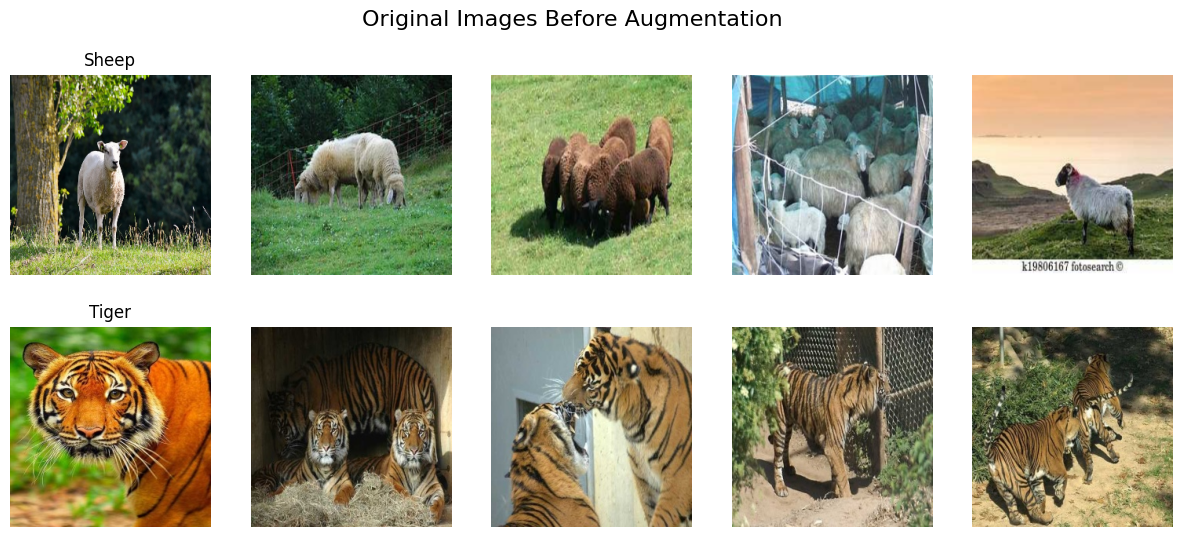

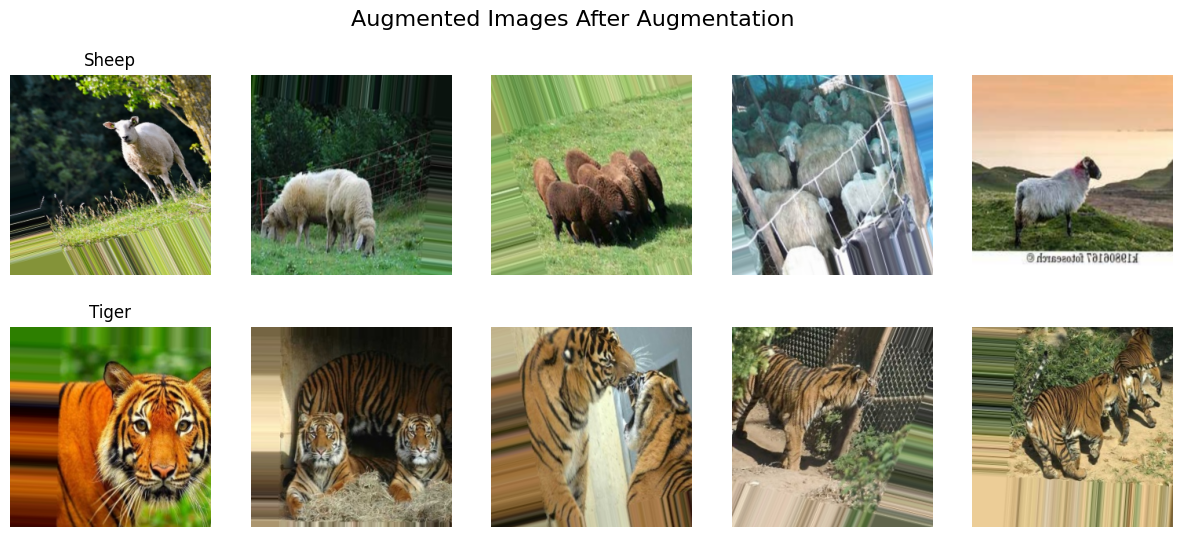

In [10]:
def display_images(images, labels, title, num_images=5, class_names=None):
    fig, axs = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    # Display images of class 0
    count = 0
    for i in range(len(images)):
        if labels[i] == 0 and count < num_images:
            if images[i].ndim == 3:  # Color image
                axs[0, count].imshow(images[i][..., ::-1])  # Convert BGR to RGB
            else:  # Grayscale image
                axs[0, count].imshow(images[i], cmap="gray")
            axs[0, count].axis('off')
            count += 1
    axs[0, 0].set_title(class_names[0])

    # Display images of class 1
    count = 0
    for i in range(len(images)):
        if labels[i] == 1 and count < num_images:
            if images[i].ndim == 3:  # Color image
                axs[1, count].imshow(images[i][..., ::-1])  # Convert BGR to RGB
            else:  # Grayscale image
                axs[1, count].imshow(images[i], cmap="gray")
            axs[1, count].axis('off')
            count += 1
    axs[1, 0].set_title(class_names[1])

    plt.show()

# Example usage
class_names = ["Sheep", "Tiger"]
display_images(X_train, y_train, title="Original Images Before Augmentation", class_names=class_names)
display_images(X_train_aug, y_train_aug, title="Augmented Images After Augmentation", class_names=class_names)


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
train_dataset_aug = tf.data.Dataset.from_tensor_slices((X_train_aug, y_train_aug))
train_dataset_aug = train_dataset_aug.shuffle(buffer_size=len(X_train_aug)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset_aug = tf.data.Dataset.from_tensor_slices((X_val_aug, y_val_aug))
test_dataset_aug = test_dataset_aug.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
# 1 Block Model
def vgg_1_block():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [14]:
# 3 Blocks Model
def vgg_3_blocks():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [15]:
def vgg_16_all():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = True
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) 
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model

In [16]:
def vgg_16_mlp():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) 
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model

In [17]:
vgg1 = vgg_1_block()  
vgg1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
vgg1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    66,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,065,537 (252.02 MB)

 Trainable params: 66,065,537 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
vgg3 = vgg_3_blocks()  
vgg3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
vgg3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
vgg3_aug = vgg_3_blocks()  
vgg3_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
vgg3_aug.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
vgg16_all= vgg_16_all()
vgg16_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
vgg16_all.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 14,780,481 (56.38 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
vgg16_mlp= vgg_16_mlp()
vgg16_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
vgg16_mlp.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
class LogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, test_dataset=None):
        super().__init__()
        self.log_dir = log_dir  # Store the log directory
        self.test_dataset = test_dataset  # Optionally store the test dataset for evaluation
        self.start_time = None
        self.writer = None

    def on_train_begin(self, logs=None):
        """ Called at the start of training """
        self.start_time = time.time()
        self.writer = tf.summary.create_file_writer(self.log_dir)

    def on_batch_end(self, batch, logs=None):
        """ Called at the end of each batch """
        step = int(self.model.optimizer.iterations.numpy())
        with self.writer.as_default():
            tf.summary.scalar('training_loss', logs['loss'], step=step)
            tf.summary.scalar('training_accuracy', logs['accuracy'], step=step)

            # Log testing accuracy every batch
            if self.test_dataset:
                test_accuracy = self.model.evaluate(self.test_dataset, verbose=0)[1]
                tf.summary.scalar('testing_accuracy', test_accuracy, step=step)

            elapsed_time = time.time() - self.start_time
            tf.summary.scalar('training_time', elapsed_time, step=step)
            self.writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        """ Called at the end of each epoch """
        elapsed_time = time.time() - self.start_time
        step = int(self.model.optimizer.iterations.numpy())
        with self.writer.as_default():
            tf.summary.scalar('training_time', elapsed_time, step=step)
        print(f"Epoch {epoch+1}: Training time so far: {elapsed_time:.2f} seconds")

    def on_train_end(self, logs=None):
        """ Called at the end of training """
        total_training_time = time.time() - self.start_time
        step = int(self.model.optimizer.iterations.numpy())
        with self.writer.as_default():
            tf.summary.scalar('total_training_time', total_training_time, step=step)
        print(f"Total training time: {total_training_time:.2f} seconds")
        self.writer.close()


In [28]:
def train(model, model_name, train_gen, test_gen, epochs=20):
    log_dir = f"logs/{model_name}"
    tensorboard_callback = TensorBoard(log_dir=log_dir, update_freq='batch', histogram_freq=1)
    log_metrics_callback = LogMetricsCallback(log_dir=log_dir, test_dataset=test_gen)

    start_time = time.time()
    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=[tensorboard_callback, log_metrics_callback]
    )
    end_time = time.time()

    training_time = end_time - start_time
    test_loss, test_accuracy = model.evaluate(test_gen)
    num_params = model.count_params()

    return {
        "Model": model_name,
        "Training Loss": history.history['loss'][-1],
        "Training Accuracy": history.history['accuracy'][-1],
        "Testing Accuracy": test_accuracy,
        "Parameters": num_params,
        "Training Time": training_time,
    }


In [29]:
# List to store metrics for each model
results = []


results.append(train(vgg1, "vgg_1", train_dataset, test_dataset))
results.append(train(vgg3, "vgg_3", train_dataset, test_dataset))
results.append(train(vgg3_aug, "vgg_3_aug", train_dataset_aug, test_dataset_aug))
results.append(train(vgg16_all, "vgg_16_all", train_dataset, test_dataset))
results.append(train(vgg16_mlp, "vgg_16_mlp", train_dataset, test_dataset))

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame(results)
print(metrics_df)

Epoch 1/20


I0000 00:00:1731699706.165691     104 service.cc:145] XLA service 0x7dd8240044e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731699706.165786     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731699709.514929     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5452 - loss: 1674.7982Epoch 1: Training time so far: 16.86 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5476 - loss: 1648.3455 
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4626 - loss: 344.4343Epoch 2: Training time so far: 27.91 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4589 - loss: 333.1127 
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5130 - loss: 122.6941Epoch 3: Training time so far: 38.15 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5129 - loss: 119.9387 
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5562 - loss: 61.7606Epoch 4: Training time so far: 48.42 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5558 - loss: 63.0302 
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5437 - loss: 90.1616Epoch 5: Training time so far: 59.44 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.5493 - loss: 88.3657

I0000 00:00:1731700056.199649     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_8', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.5769 - loss: 2.0933Epoch 1: Training time so far: 37.38 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 758ms/step - accuracy: 0.5810 - loss: 1.9105
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6587 - loss: 0.6472Epoch 2: Training time so far: 40.74 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 751ms/step - accuracy: 0.6600 - loss: 0.6494
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7279 - loss: 0.5889Epoch 3: Training time so far: 44.18 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 772ms/step - accuracy: 0.7266 - loss: 0.5851
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6961 - loss: 0.6581Epoch 4: Training time so far: 47.66 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - accuracy: 0.6892 - loss: 0.6680
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6384 - loss: 0.6728Epoch 5: Training time so far: 51.01 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - accuracy: 0.6441 - loss: 0.6689
Epoch

In [30]:
from PIL import Image

def log_test_images_with_predictions(model, log_dir, test_dataset):
    # Create TensorBoard writer
    file_writer = tf.summary.create_file_writer(log_dir + "/images")

    step = 0
    with file_writer.as_default():
        for test_images, test_labels in test_dataset:
            predictions = model.predict(test_images)

            for i in range(len(test_images)):
                fig, ax = plt.subplots(figsize=(4, 4))
                ax.imshow(test_images[i].numpy().astype("uint8"))
                label = "Tiger" if predictions[i] > 0.5 else "Sheep"
                true_label = "Tiger" if test_labels[i] > 0 else "Sheep"
                ax.set_title(f"Pred: {label} | True: {true_label}", fontsize=10)
                ax.axis("off")
                
                buf = io.BytesIO()
                plt.savefig(buf, format='png')
                plt.close(fig) 
                buf.seek(0)
                image = tf.image.decode_png(buf.getvalue(), channels=4)
                image = tf.expand_dims(image, 0)
                tf.summary.image(f"Test Image {step + 1}", image, step=step)
                step += 1


log_test_images_with_predictions(vgg1, "logs/vgg_1", test_dataset)
log_test_images_with_predictions(vgg3, "logs/vgg_3", test_dataset)
log_test_images_with_predictions(vgg3_aug, "logs/vgg_3_aug", test_dataset)
log_test_images_with_predictions(vgg16_all, "logs/vgg_16_all", test_dataset)
log_test_images_with_predictions(vgg16_mlp, "logs/vgg_16_mlp", test_dataset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


In [31]:
# Define a comparable MLP model
def mlp_model():
    model = Sequential([
        Flatten(input_shape=(256, 256, 3)), 
        Dense(64, activation='relu'),     
        Dense(64, activation='relu'),     
        Dense(32, activation='relu'),      
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [32]:
mlp= mlp_model()
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
mlp.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    12,582,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,589,249 (48.02 MB)

 Trainable params: 12,589,249 (48.02 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
results.append(train(mlp, "mlp", train_dataset, test_dataset))
metrics_df = pd.DataFrame(results)
print(metrics_df)

Epoch 1/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6250 - loss: 65.8000Epoch 1: Training time so far: 4.67 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 464ms/step - accuracy: 0.5084 - loss: 306.8395
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4375 - loss: 15.7347Epoch 2: Training time so far: 6.73 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.4833 - loss: 149.0010
Epoch 3/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5312 - loss: 158.5401Epoch 3: Training time so far: 8.68 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.5375 - loss: 84.2711
Epoch 4/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5000 - loss: 54.5426Epoch 4: Training time so far: 10.49 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.4631 - loss: 70.1980
Epoch 5/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6250 - loss: 32.6463Epoch 5: Training time so far: 12.37 seconds
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.6458 - loss:

In [35]:

log_test_images_with_predictions(mlp, "logs/mlp", test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


## Testing on Generated Images

In [36]:
images = []
for files in os.listdir("/kaggle/input/gen-animals/Animals/Sheep"):
    if len(images)==100:
        break
    img = cv2.imread(f"/kaggle/input/gen-animals/Animals/Sheep/{files}")
    img = cv2.resize(img,(256,256))
    images.append(img)

images_t = []
for files in os.listdir("/kaggle/input/gen-animals/Animals/Tiger"):
    if len(images_t)==100:
        break
    img = cv2.imread(f"/kaggle/input/gen-animals/Animals/Tiger/{files}")
    img = cv2.resize(img,(256,256))
    images_t.append(img)

In [38]:
label1 = [0 for char in range(8)]
label2 = [1 for char in range(8)]
labels = label1+label2

labels = np.array(labels)
images = np.array(images+images_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
VGG 1 Accuracy: 62.50%


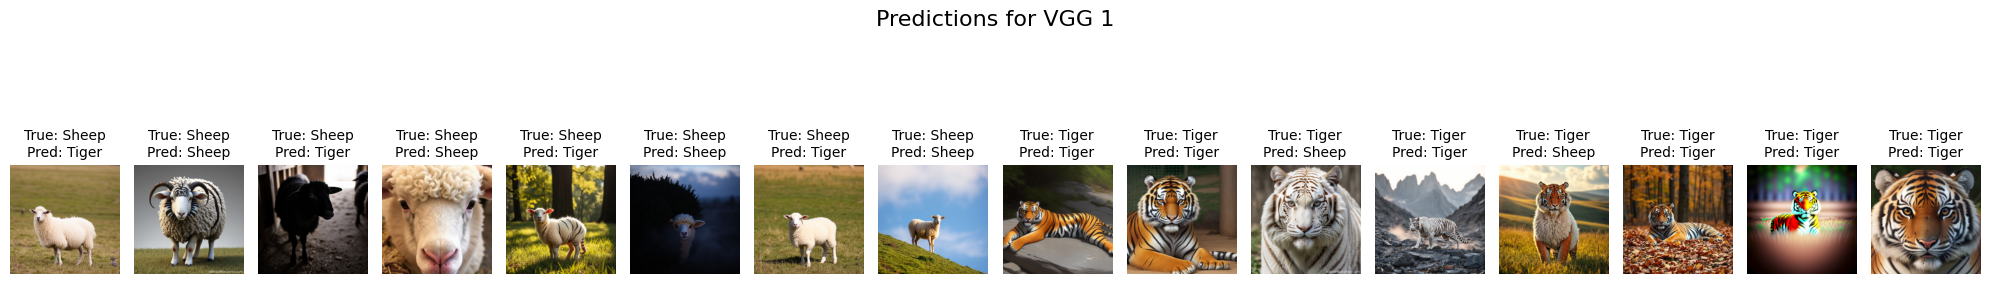

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
VGG 3 Accuracy: 68.75%


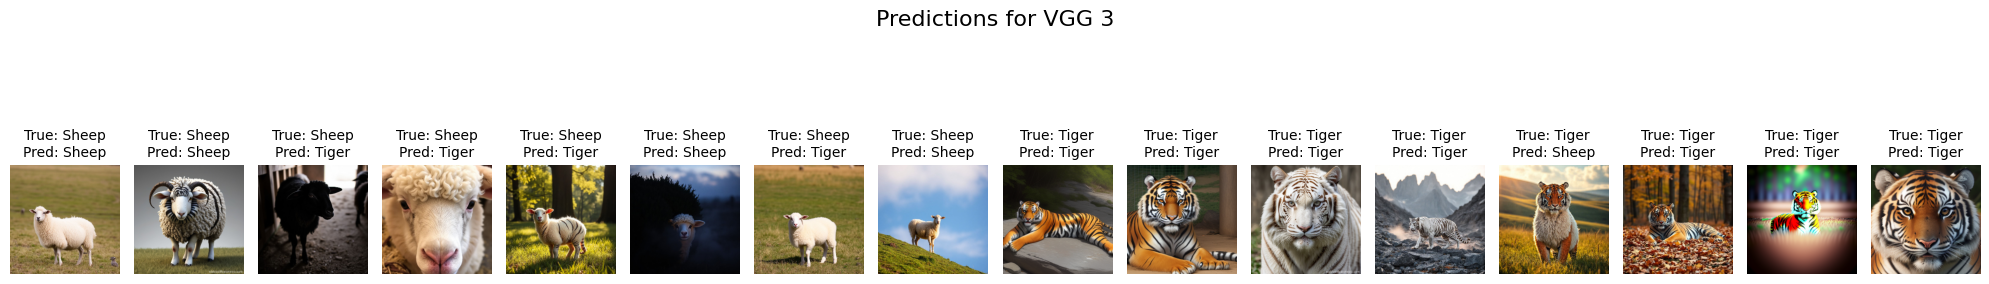

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
VGG 3 Aug Accuracy: 62.50%


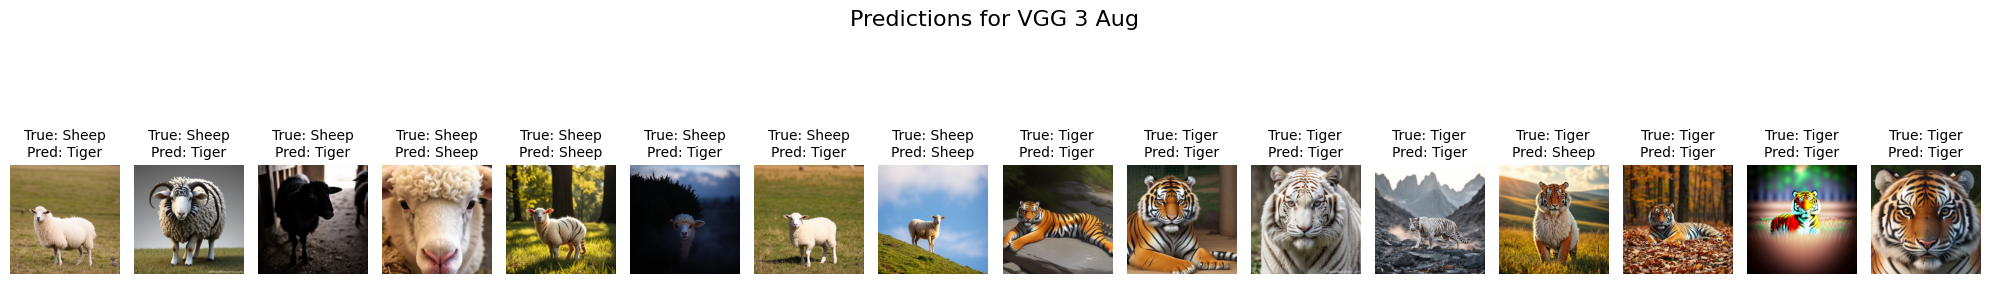

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
VGG 16 All Accuracy: 75.00%


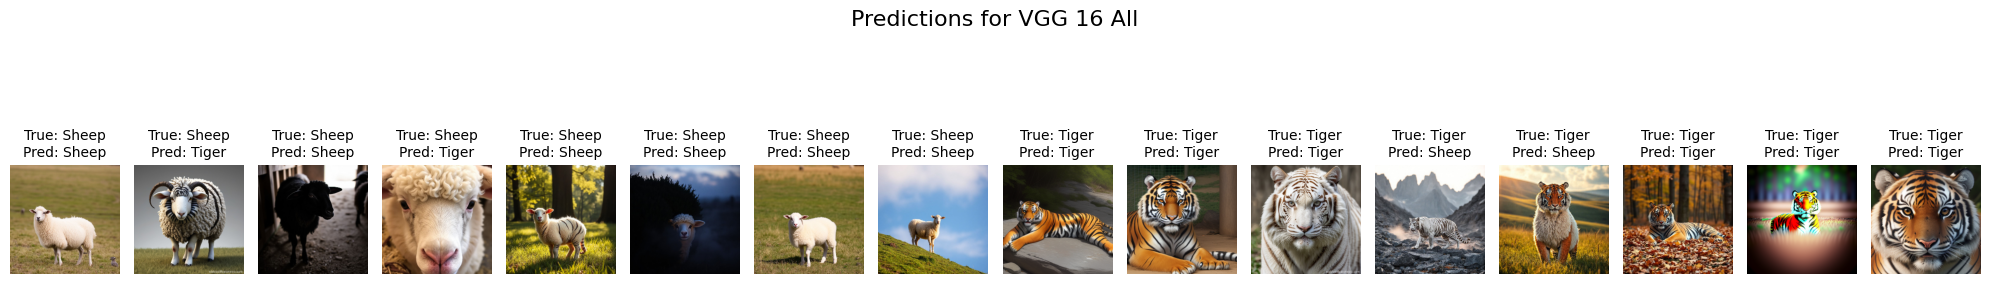

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
VGG 16 MLP Accuracy: 93.75%


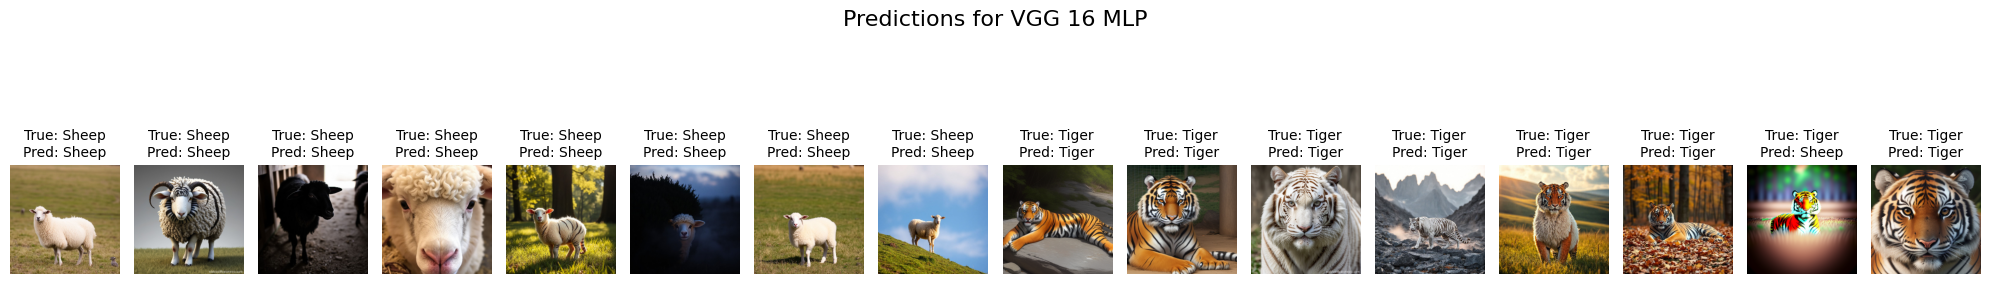

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MLP Accuracy: 50.00%


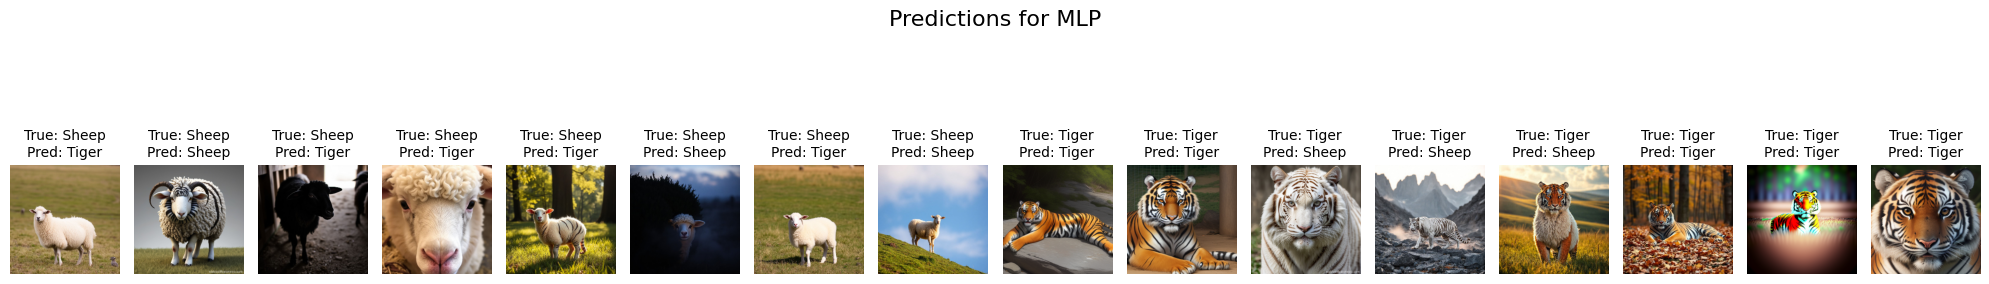

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_on_images(model, name, images, labels):
    predictions = model.predict(images)
    predicted_classes = np.array([0 if (i < 0.5) else 1 for i in predictions])
    
    # Calculate accuracy
    accuracy = np.sum(predicted_classes == labels) / len(labels)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    
    # Display all images in a row with predictions
    fig, axes = plt.subplots(1, len(images), figsize=(20,4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i][..., ::-1].astype("uint8"))
        ax.set_title(
            f"True: {'Sheep' if labels[i] == 0 else 'Tiger'}\n"
            f"Pred: {'Sheep' if predicted_classes[i] == 0 else 'Tiger'}",
            fontsize=10,
        )
        ax.axis("off")
    plt.suptitle(f"Predictions for {name}", fontsize=16)
    plt.tight_layout()
    plt.show()

    return accuracy


models = [vgg1, vgg3, vgg3_aug, vgg16_all, vgg16_mlp, mlp]
model_names = ["VGG 1", "VGG 3", "VGG 3 Aug", "VGG 16 All", "VGG 16 MLP", "MLP"]

for model, name in zip(models, model_names):
    evaluate_model_on_images(model, name, images, labels)


In [40]:
import shutil
# Create a zip file of the logs directory
shutil.make_archive('/kaggle/working/tensorboard_logs', 'zip', '/kaggle/working/logs')

'/kaggle/working/tensorboard_logs.zip'